In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

# Loading datasets 

In [2]:
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

data_path = './data/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

imdb_movies = pd.read_csv(data_path+'title_basics.tsv', sep='\t')
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')
cmu_movies = pd.read_csv(data_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_character = pd.read_table(data_path+'character.metadata.tsv', names=cmu_character_cols)
acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)

/tmp/ipykernel_3938/1405530613.py:37: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_movies = pd.read_csv(data_path+'title_basics.tsv', sep='\t')


In [3]:
#merge with their ratings
imdb_movies = imdb_movies[['tconst','primaryTitle','startYear']].merge(imdb_ratings,how='inner',on='tconst')

#lower(title)
imdb_movies = imdb_movies[imdb_movies['primaryTitle'].apply(lambda x : type(x))==str]
imdb_movies['primaryTitle'] = imdb_movies['primaryTitle'].apply(lambda x : x.lower())

imdb_movies = imdb_movies.sort_values(by=['primaryTitle','numVotes'],ascending=[True,False])

imdb_movies = imdb_movies.drop_duplicates(subset=['primaryTitle','startYear'])

In [4]:
cmu_movies['movie_name'] = cmu_movies['movie_name'].apply(lambda x : x.lower())

In [5]:
cmu_imdb_movies = cmu_movies.merge(imdb_movies,left_on='movie_name',right_on='primaryTitle')
cmu_imdb_movies = cmu_imdb_movies[~cmu_imdb_movies.duplicated(subset=['wikiID'],keep=False)]

In [6]:
# As IMDB has no missing values for the movie's year of release, for missing values in CMU we take the one from IMDB but keep information of months and days when available
cmu_imdb_movies.loc[cmu_imdb_movies['release_date'].isna(), 'release_date']=cmu_imdb_movies.loc[cmu_imdb_movies['release_date'].isna(), 'startYear']

In [7]:
cmu_movies = cmu_movies.drop('release_date',axis=1).merge(cmu_imdb_movies[['wikiID','averageRating','numVotes','release_date']],on='wikiID',how='inner')

## Let's put data in a more convenient format

### Release Dates

In [8]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

We can see when only the year was present in the original dataset, the formated date added the first day of the year to make it a valid format. This is not an issue since we will only use the years for our analysis.
We will now drop the original date column, only keep years and rename the new one to release_year.   TO BE CHECKEEEEEEEEEEEEEEEEEEEEEEEEED

In [9]:
#Check if too many NaT values appears (in that case, we will have to either drop the rows or try to fix the date manually)
print('The percentage of NaT values is: ', cmu_movies['release_date'].isna().mean()*100, '%')

The percentage of NaT values is:  0.0 %


We will accept this amount of NaT (we still have close to 70k movies with a release year).  TO BE CHECKEEEEEEEEEEEEEEEEEEEEEEEEED

We still keep the movies NaT in case other variables are still useful.

In [10]:
#Checking if years are consistent (not a future or too old year)
cmu_movies['release_date'].describe()

count                            37529
mean     1979-07-03 14:27:05.558901056
min                1878-01-01 00:00:00
25%                1958-01-01 00:00:00
50%                1987-01-01 00:00:00
75%                2004-04-01 00:00:00
max                2023-01-01 00:00:00
Name: release_date, dtype: object

The min (1888) and max (2016) values are reasonable. we may drop some of the years based on the number of movies that specific year.

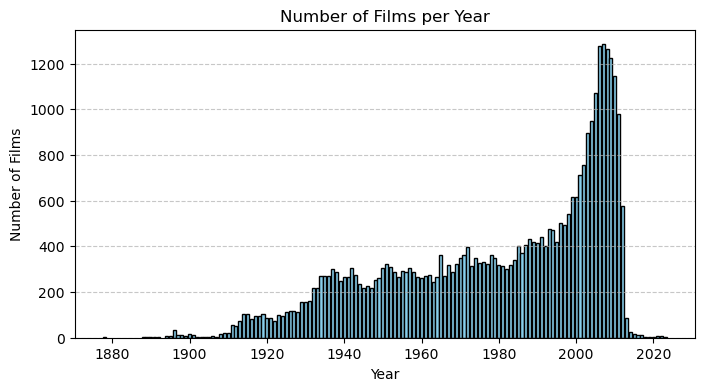

In [11]:
# Plotting the bar plot
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')).reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [12]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the number of films for year 2010
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 45
Number of years with less than 500 films: 120
Number of years with less than 1000 films: 130
The year with the max number of films is: 2007 with 1284 films


There are not a lot of films with less than 100 movies per year. We will remove these years from the dataset without losing too much information.  TO BE CHECKEEEEEEEEEEEEEEEEEEEEEEEEED

In [13]:
#In the original CMU dataset remove the rows with release year with less than 100 films

years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)]


#test if the rows have been removed
print(f'The minimum number of film in a year is {cmu_movies.release_date.dt.year.value_counts().min()} in year {cmu_movies.release_date.dt.year.value_counts().idxmin()}')


The minimum number of film in a year is 102 in year 1919


### Dictionnaries

We can notice 3 columns contains dictionnaries: langage, country and genre. We will now extract the information from these columns and create new columns for each of the values.

In [14]:
#Split the dictionnary values into list:

cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) #we use ast.literal_eval to convert the string into a dictionnary since if we directly use x.values() it return empty list
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

#Check the max number of values in each list (i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


Clearly we can't split each value in a new column. But we don't need to keep the keys from the dictionnaries so we will keep these lists of values 

# Cleaning the Character dataset

In [15]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)

actor_movie = cmu_character[['wikiID','freebase_actorID']].merge(cmu_movies[['wikiID','averageRating','numVotes','release_date']],on='wikiID',how='inner')
actor_movie = actor_movie.drop_duplicates(subset=['wikiID','freebase_actorID']) # if same film same actor
actor_movie = actor_movie.dropna(subset='averageRating')
actor_movie = actor_movie.sort_values(by=['freebase_actorID','release_date'])
actor_movie.reset_index(drop=True,inplace=True)
actor_movie.reset_index(inplace=True)

In [16]:
def fame_score(row,data):
    n = row['index']
    rowm1 = data.iloc[n-1]
    rowm2 = data.iloc[n-2]

    actor = row['freebase_actorID']
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']

    fame_score = rate * np.log(votes) / (year-1700)

    if rowm2['freebase_actorID'] == actor:
        year = rowm2['release_date'].year
        rate = rowm2['averageRating'] 
        votes = rowm2['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    if rowm1['freebase_actorID'] == actor:
        year = rowm1['release_date'].year
        rate = rowm1['averageRating']
        votes = rowm1['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    return fame_score

In [17]:
# Apply the function to each row
actor_movie['fameScore'] = actor_movie.apply(lambda x: fame_score(x,actor_movie), axis=1)
actor_movie.drop('index',inplace=True,axis=1)

In [18]:
cmu_character = cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID']).drop(columns='release_date', axis=1)
cmu_character = cmu_character.merge(actor_movie[['freebase_actorID','wikiID', 'fameScore','release_date']], on=['freebase_actorID','wikiID'])

In [19]:
# Include character persona in cmu_character
acl_persona = acl_persona[acl_persona['entity_id'].apply(lambda x : not x.startswith('e'))].rename(columns={'entity_id':'freebase_char_actor_map'})
cmu_character = cmu_character.merge(acl_persona[['freebase_char_actor_map','persona']], on='freebase_char_actor_map', how='left')

# Persona Analysis
The goal in this part is to obtain the relation between actor characteristics and the kind of chararcters they play (persona) when they have a big fame score

- First, we only select in the table the row with full usefull data for this analysis
- Then we only want the actor with the best fame score. We decide to take the first half all actors

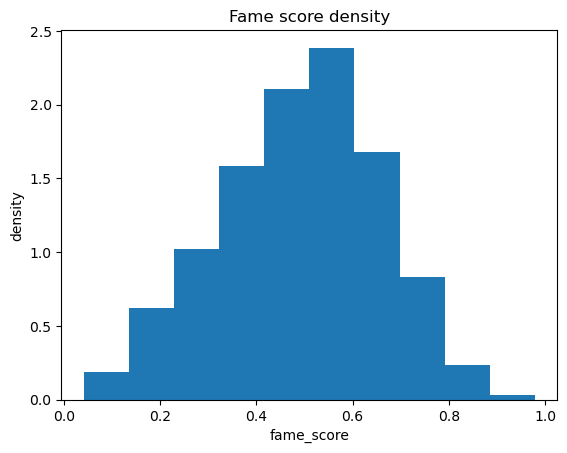

,actor_gender,actor_height,actor_ethnicity,actor_age_at_release,persona,fameScore
1,F,1.780,/m/044038p,27.0,35,0.521356
58,M,1.720,/m/0dryh9k,28.0,36,0.508337
114,M,1.750,/m/09kr66,35.0,36,0.539630
150,M,1.700,/m/02w7gg,49.0,35,0.506381
201,M,1.700,/m/0xnvg,39.0,40,0.697887
...,...,...,...,...,...,...
199250,F,1.710,/m/065b6q,31.0,9,0.650857
199295,M,1.797,/m/02w7gg,37.0,11,0.532804
199470,F,1.750,/m/065b6q,49.0,49,0.625193
199472,F,1.600,/m/03ts0c,36.0,13,0.772679


In [80]:
cmu_chara_persona = cmu_character[['actor_gender','actor_height','actor_ethnicity','actor_age_at_release','persona','fameScore']].copy()
cmu_chara_persona = cmu_chara_persona.dropna()
cmu_chara_persona['persona'] = cmu_chara_persona['persona'].apply(lambda x : str(int(x)))

plt.hist(cmu_chara_persona['fameScore'],density=True)
plt.title('Fame score density')
plt.xlabel('fame_score'), plt.ylabel('density')
plt.show()

cmu_chara_persona = cmu_chara_persona.query('fameScore>0.5')
cmu_chara_persona

- We observe that some personas and ethnicity are not assigned to enough actor. Then we remove them from this analysis.

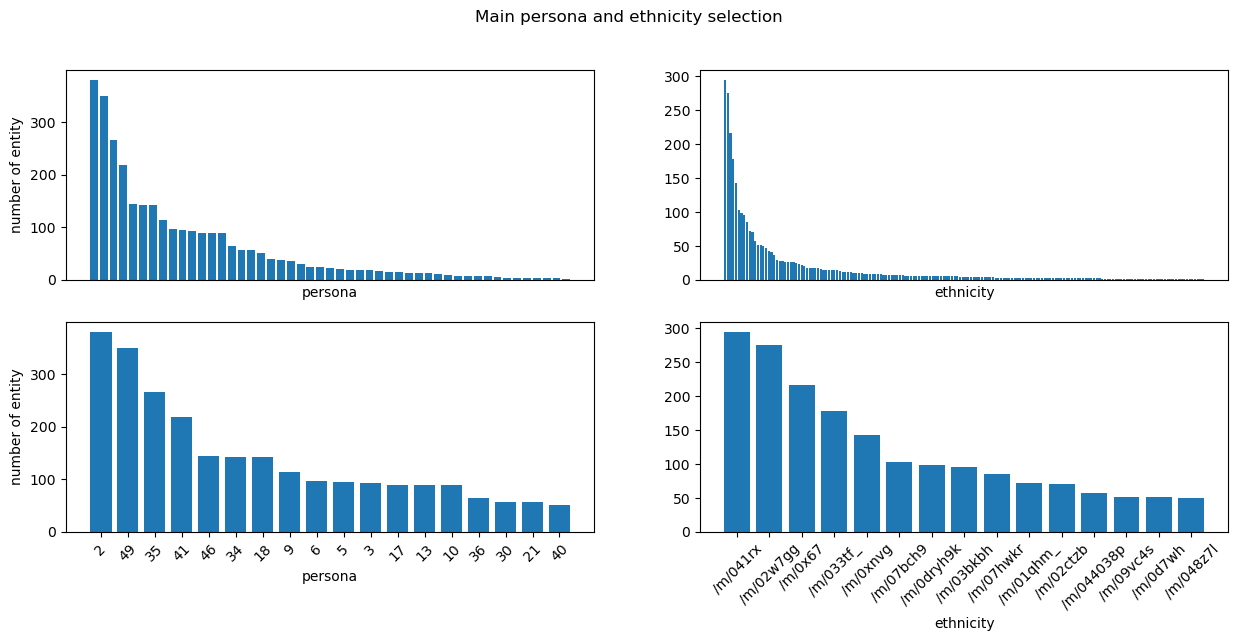

In [81]:
persona_count = cmu_chara_persona[['persona','actor_ethnicity']].groupby('persona',as_index=False).count().rename(columns={'actor_ethnicity':'count'})
persona_count.sort_values('count',inplace=True,ascending=False)
ethnicity_count = cmu_chara_persona[['persona','actor_ethnicity']].groupby('actor_ethnicity',as_index=False).count().rename(columns={'persona':'count'})
ethnicity_count.sort_values('count',inplace=True,ascending=False)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
fig.suptitle('Main persona and ethnicity selection')

axes[0,0].bar(persona_count['persona'],persona_count['count'])
axes[0,1].bar(ethnicity_count['actor_ethnicity'],ethnicity_count['count'])

for ax in axes[0,:]:
    ax.set_xticks([])

persona_count = persona_count.query('count >= 50')
ethnicity_count = ethnicity_count.query('count >= 50')

axes[1,0].bar(persona_count['persona'],persona_count['count'])
axes[1,1].bar(ethnicity_count['actor_ethnicity'],ethnicity_count['count'])

for ax in axes[1,:]:
    ax.tick_params(axis='x', rotation=45)
for ax in axes[:,0]:
    ax.set_xlabel('persona')
    ax.set_ylabel('number of entity')
for ax in axes[:,1]:
    ax.set_xlabel('ethnicity') 

cmu_chara_persona = cmu_chara_persona.merge(persona_count['persona'],on='persona',how='right')
cmu_chara_persona = cmu_chara_persona.merge(ethnicity_count['actor_ethnicity'],on='actor_ethnicity',how='right')

- For the further analysis, the '/' in the actor_ethnicity id will cause problem to the algorithm. We decide to change them to a code_number here
- get_dummies is use to separate the categorical variables as 'persona' and the 'actor_ethnicity'

In [82]:
ethnicity_code_nbr = ethnicity_count['actor_ethnicity'].reset_index(drop=True).reset_index().rename(columns={'index':'ethni_nbr'})

cmu_chara_persona = cmu_chara_persona.merge(ethnicity_code_nbr,on='actor_ethnicity')
cmu_chara_persona_analysis = pd.get_dummies(cmu_chara_persona,columns=['persona','actor_gender','ethni_nbr'])

- Finally, a logistic regression is performed for each persona. Here is the example for persona_5. We first perform the regression with all the caracteristics and then remove the the ones without influence to play this persona.

In [85]:
import statsmodels.formula.api as smf

persona_count.sort_values('persona')

p = 5 # logistic model done for persona_5
persona = 'persona_'+str(p)
cmu_chara_persona_analysis[persona] = cmu_chara_persona_analysis[persona].astype(int)

mod = smf.logit(formula=persona+' ~  C(actor_gender_M) + actor_age_at_release + actor_height +' + 
            'C(ethni_nbr_0) + C(ethni_nbr_1) + C(ethni_nbr_2) + C(ethni_nbr_3) +'+
            'C(ethni_nbr_4) + C(ethni_nbr_5) + C(ethni_nbr_6) + C(ethni_nbr_7) +'+ 
            'C(ethni_nbr_8) + C(ethni_nbr_9) + C(ethni_nbr_10) + C(ethni_nbr_11) +'+ 
            'C(ethni_nbr_12) + C(ethni_nbr_13)', 
            data=cmu_chara_persona_analysis)

res = mod.fit()


high_p_values = res.pvalues[res.pvalues > 0.05].index #we only keep relevant features
high_p_values = high_p_values.drop('Intercept', errors='ignore')

new_formula = persona + ' ~ ' + ' + '.join([col for col in mod.exog_names if col not in high_p_values][1:]) #new formula for regression
new_formula = new_formula.replace('[T.True]', '')

new_mod = smf.logit(formula=new_formula, data=cmu_chara_persona_analysis)
new_res = new_mod.fit()

print(new_res.summary())
# res = [res, mod.fit()]

    

Optimization terminated successfully.
         Current function value: 0.146567
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.151302
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              persona_5   No. Observations:                 1553
Model:                          Logit   Df Residuals:                     1550
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Nov 2023   Pseudo R-squ.:                  0.1294
Time:                        09:50:46   Log-Likelihood:                -234.97
converged:                       True   LL-Null:                       -269.90
Covariance Type:            nonrobust   LLR p-value:                 6.764e-16
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

The $R²$ value is fairly high $0.13$ and the remain characteristics are all statically significant in this logistic model.